# Preprocess

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./US-Economic-News.csv", delimiter=',', encoding= 'ISO-8859-1')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               8000 non-null   int64  
 1   _golden                8000 non-null   bool   
 2   _unit_state            8000 non-null   object 
 3   _trusted_judgments     8000 non-null   int64  
 4   _last_judgment_at      8000 non-null   object 
 5   positivity             1420 non-null   float64
 6   positivity:confidence  3775 non-null   float64
 7   relevance              8000 non-null   object 
 8   relevance:confidence   8000 non-null   float64
 9   articleid              8000 non-null   object 
 10  date                   8000 non-null   object 
 11  headline               8000 non-null   object 
 12  positivity_gold        0 non-null      float64
 13  relevance_gold         0 non-null      float64
 14  text                   8000 non-null   object 
dtypes: b

In [3]:
df.head(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [4]:
df = df[['headline', 'text', 'relevance']]

# We drop all irrelavant features to only keep headline and text for 2 reasons: 
# The other features seem either irrelevant or we lack documentation
# With headline and text only, our final model will be more generalizable. We could in theory apply it to any article.

In [5]:
import pandas as pd
import numpy as np

df_yes = df[df['relevance'] == 'yes']
df_no = df[df['relevance'] == 'no']

df_no_sampled = df_no.sample(n=len(df_yes), random_state=42)

# Concatenate the sampled 'no' rows with all 'yes' rows
df_balanced = pd.concat([df_yes, df_no_sampled])

print(df_balanced['relevance'].value_counts())

relevance
yes    1420
no     1420
Name: count, dtype: int64


In [6]:
df = df_balanced

Cleaning Strings

In [7]:
#!pip install nltk

In [8]:
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [9]:
# #Ensure you have downloaded the necessary NLTK data
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [10]:
df['whole_txt'] = df['headline']+ ' ' + df['text']

In [11]:
wtxt_train = np.array(df['whole_txt'])

In [12]:
#print(wtxt_train)

In [13]:
for i in range(len(wtxt_train)):
    # Taking out '<br>' in the 'whole_text' column
    wtxt_train[i] = re.sub(r'</?br>', ' ', wtxt_train[i])
    # Deletion of non-latin alfabet signs, also numbers
    wtxt_train[i] = re.sub(r'[^a-zA-Z]', ' ', wtxt_train[i])
    # Removing single letter works like 'a'.
    wtxt_train[i] = re.sub(r"\s+[a-zA-Z]\s+", ' ', wtxt_train[i])
    # Removing double spaces
    wtxt_train[i] = re.sub(r'\s+', ' ', wtxt_train[i])
    # Lower case
    wtxt_train[i] = wtxt_train[i].lower()

Split the words.

In [14]:
for i in range(len(wtxt_train)):
    wtxt_train[i] = word_tokenize(wtxt_train[i])

Removing stop words

In [15]:
stop_words = set(stopwords.words('english'))

for i in range(len(wtxt_train)):
    wtxt_train[i] = [word for word in wtxt_train[i] if word not in stop_words]

In [16]:
wtxt_train[0]
# stop_words

['yields',
 'cds',
 'fell',
 'latest',
 'week',
 'new',
 'york',
 'yields',
 'certificates',
 'deposit',
 'offered',
 'major',
 'banks',
 'dropped',
 'tenth',
 'percentage',
 'point',
 'latest',
 'week',
 'reflecting',
 'overall',
 'decline',
 'short',
 'term',
 'interest',
 'rates',
 'small',
 'denomination',
 'consumer',
 'cds',
 'sold',
 'directly',
 'banks',
 'average',
 'yield',
 'six',
 'month',
 'deposits',
 'fell',
 'week',
 'ended',
 'yesterday',
 'according',
 'bank',
 'survey',
 'banxquote',
 'money',
 'markets',
 'wilmington',
 'del',
 'information',
 'service',
 'three',
 'month',
 'consumer',
 'deposits',
 'average',
 'yield',
 'sank',
 'week',
 'according',
 'banxquote',
 'two',
 'banks',
 'banxquote',
 'survey',
 'citibank',
 'new',
 'york',
 'corestates',
 'pennsylvania',
 'paying',
 'less',
 'threemonth',
 'small',
 'denomination',
 'cds',
 'declines',
 'somewhat',
 'smaller',
 'five',
 'year',
 'consumer',
 'cds',
 'eased',
 'banxquote',
 'said',
 'yields',
 'three',

Lemmatization

In [17]:
lemmatizer = WordNetLemmatizer()
for i in range(len(wtxt_train)):
    wtxt_train[i] = [lemmatizer.lemmatize(word) for word in wtxt_train[i]]

In [18]:
df['whole_txt'] = wtxt_train
df = df.drop(['headline', 'text'], axis = 1)

In [19]:
df.head(5)

,relevance,whole_txt
0,yes,"[yield, cd, fell, latest, week, new, york, yie..."
4,yes,"[currency, trading, dollar, remains, tight, ra..."
5,yes,"[stock, fall, bofa, alcoa, slide, stock, decli..."
9,yes,"[u, dollar, fall, currency, decline, softened,..."
12,yes,"[defending, deflation, author, james, stewart,..."


In [72]:
## Importing Libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

### Data preparation
* Initial Data Processing: Our first step is to encode the relevance label into both the Relevant (1) and non-Relevant labels (0). Then, we make it into a np.array to feed into the model.
* Then, we begin to clean text data into pad sequences.

In [21]:
df.update(df["relevance"].apply(lambda x: 0 if x == "no" else 1))

In [22]:
df.head(5)

,relevance,whole_txt
0,1,"[yield, cd, fell, latest, week, new, york, yie..."
4,1,"[currency, trading, dollar, remains, tight, ra..."
5,1,"[stock, fall, bofa, alcoa, slide, stock, decli..."
9,1,"[u, dollar, fall, currency, decline, softened,..."
12,1,"[defending, deflation, author, james, stewart,..."


### Tokenization
First, we need to "tokenize" our sentences, i.e., convert them to sequences of numbers. For this task, we are going to use the `Tokenizer` from Tensorflow (documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer))

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(wtxt_train)   # fit our tokenizer on the dataset (i.e., assign a number to each word and keep a
                                    # dictionary with the correspondence of each word to a number)

# see the language dictionary and the total number of words (please note that number 0 is reserved for the padding task)
word_index = tokenizer.word_index
total_words = len(word_index) + 1

In [24]:
word_index

{'year': 1,
 'rate': 2,
 'market': 3,
 'said': 4,
 'stock': 5,
 'price': 6,
 'new': 7,
 'economy': 8,
 'economic': 9,
 'month': 10,
 'federal': 11,
 'would': 12,
 'interest': 13,
 'percent': 14,
 'last': 15,
 'week': 16,
 'inflation': 17,
 'bank': 18,
 'billion': 19,
 'fed': 20,
 'dollar': 21,
 'bond': 22,
 'point': 23,
 'growth': 24,
 'investor': 25,
 'one': 26,
 'company': 27,
 'million': 28,
 'index': 29,
 'since': 30,
 'york': 31,
 'quarter': 32,
 'average': 33,
 'first': 34,
 'time': 35,
 'tax': 36,
 'increase': 37,
 'reserve': 38,
 'may': 39,
 'government': 40,
 'president': 41,
 'report': 42,
 'business': 43,
 'day': 44,
 'rose': 45,
 'say': 46,
 'consumer': 47,
 'also': 48,
 'yesterday': 49,
 'two': 50,
 'economist': 51,
 'dow': 52,
 'sale': 53,
 'many': 54,
 'job': 55,
 'fund': 56,
 'share': 57,
 'could': 58,
 'high': 59,
 'gain': 60,
 'higher': 61,
 'trading': 62,
 'cut': 63,
 'deficit': 64,
 'state': 65,
 'analyst': 66,
 'decline': 67,
 'money': 68,
 'spending': 69,
 'fell':

In [25]:
total_words

20936

### Padding Sequences
Sentences and sequences tend to have different lengths, however our model is expecting equally sized observations.
Here we want to convert our texts to sequences and make them of the same length (in general, the lenght of the longest of our sequences). We are going to use here `pad_sequences` from Tensorflow (documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences)), to add zeroes to the tokenized sentences until they all reach the same length.

In [26]:
sequences = tokenizer.texts_to_sequences(wtxt_train)
padded_sequences = pad_sequences(sequences)

In [27]:
sequences[0]

[143,
 2582,
 70,
 297,
 16,
 7,
 31,
 143,
 2405,
 816,
 932,
 138,
 18,
 299,
 2041,
 286,
 23,
 297,
 16,
 1055,
 400,
 67,
 130,
 74,
 13,
 2,
 214,
 7581,
 47,
 2582,
 609,
 1698,
 18,
 33,
 143,
 285,
 10,
 816,
 70,
 16,
 298,
 49,
 132,
 18,
 247,
 6514,
 68,
 3,
 12016,
 3663,
 743,
 135,
 98,
 10,
 47,
 816,
 33,
 143,
 1832,
 16,
 132,
 6514,
 50,
 18,
 6514,
 247,
 3307,
 7,
 31,
 12017,
 3308,
 1042,
 133,
 12018,
 214,
 7581,
 2582,
 67,
 1020,
 772,
 271,
 1,
 47,
 2582,
 1165,
 6514,
 4,
 143,
 98,
 10,
 285,
 10,
 75,
 174,
 609,
 300,
 1056,
 2042,
 1110,
 286,
 23,
 311,
 16,
 2406]

In [28]:
padded_sequences

array([[    0,     0,     0, ...,   311,    16,  2406],
       [    0,     0,     0, ...,   239,   232,    42],
       [    0,     0,     0, ...,   325,   326,    23],
       ...,
       [    0,     0,     0, ...,   203,  4375,    59],
       [    0,     0,     0, ...,   159,     9,   169],
       [    0,     0,     0, ..., 12015,  7108,  7444]])

In [29]:
df['pad_seq'] = padded_sequences.tolist()

In [30]:
df.drop(['whole_txt'], axis = 1)

,relevance,pad_seq
0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
12,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
7810,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
677,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4794,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5869,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [31]:
df.head(5)

,relevance,whole_txt,pad_seq
0,1,"[yield, cd, fell, latest, week, new, york, yie...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,"[currency, trading, dollar, remains, tight, ra...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,1,"[stock, fall, bofa, alcoa, slide, stock, decli...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,1,"[u, dollar, fall, currency, decline, softened,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
12,1,"[defending, deflation, author, james, stewart,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Train-Test Split

In [32]:
X = padded_sequences
y = df['relevance']

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=42)

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,  test_size=0.2, random_state=42)

In [35]:
X_train

array([[   0,    0,    0, ...,   61,  362,   66],
       [   0,    0,    0, ..., 4569, 6281, 1252],
       [   0,    0,    0, ..., 3415,   95,    4],
       ...,
       [   0,    0,    0, ...,  479,   96,   64],
       [   0,    0,    0, ...,   27,  246,  609],
       [   0,    0,    0, ...,   10,  391,   24]])

In [36]:
X_train.shape

(1817, 404)

In [37]:
y_train

6965    1
2156    0
1103    0
7486    1
5865    1
       ..
2245    1
1956    1
3711    0
506     1
3821    1
Name: relevance, Length: 1817, dtype: object

In [38]:
y_train.shape

(1817,)

In [39]:
y_val.shape

(455,)

In [40]:
y_test.shape

(568,)

In [41]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [42]:
y_train = y_train.astype('int')
y_val = y_val.astype('int')
y_test = y_test.astype('int')

### Building the model

We are going to build a simple model that includes:
- `Embedding` layer with an output representation of each word as a vector of dim 16
- `LSTM` (see class slides for more detail or RNNs example notebook for more details) with an intermediate state of 100
- An output layer `Dense` that connects the output of the LSTM and creates an output of 3 positions (one per class) as output of the network

That is model nr.1 

In [43]:
# We are going to build our model with the Sequential API
model = Sequential()
model.add(Embedding(total_words,      # number of words to process as input
                    100,    # output representation
                    input_length=len(padded_sequences[0])))    # total length of each observation
model.add(LSTM(100, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))  # Change activation based on the number of classes

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
model(padded_sequences)

<tf.Tensor: shape=(2840, 1), dtype=float32, numpy=
array([[0.5006623 ],
       [0.5007331 ],
       [0.4986714 ],
       ...,
       [0.49953288],
       [0.50375706],
       [0.4991562 ]], dtype=float32)>

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 404, 100)          2093600   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 2174101 (8.29 MB)
Trainable params: 2174101 (8.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Early Stopping


In [62]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the models

### MODEL 1 (The base model)

In [46]:
hist = model.fit(X_train, y_train, epochs=10, validation_data = (X_val, y_val))

Epoch 1/10


57/57 [==============================] - 12s 172ms/step - loss: 0.6896 - accuracy: 0.5388 - val_loss: 0.6746 - val_accuracy: 0.5714
Epoch 2/10
57/57 [==============================] - 9s 165ms/step - loss: 0.5323 - accuracy: 0.7683 - val_loss: 0.6840 - val_accuracy: 0.6593
Epoch 3/10
57/57 [==============================] - 9s 164ms/step - loss: 0.2262 - accuracy: 0.9213 - val_loss: 0.8153 - val_accuracy: 0.5934
Epoch 4/10
57/57 [==============================] - 10s 168ms/step - loss: 0.0755 - accuracy: 0.9796 - val_loss: 1.2775 - val_accuracy: 0.5956
Epoch 5/10
57/57 [==============================] - 9s 166ms/step - loss: 0.0247 - accuracy: 0.9945 - val_loss: 1.4006 - val_accuracy: 0.5692
Epoch 6/10
57/57 [==============================] - 9s 166ms/step - loss: 0.0156 - accuracy: 0.9945 - val_loss: 1.8238 - val_accuracy: 0.5824
Epoch 7/10
57/57 [==============================] - 9s 166ms/step - loss: 0.0070 - accuracy: 0.9994 - val_loss: 1.8439 - val_accuracy: 0.5868
Ep

In [47]:
hist.history

{'loss': [0.6895917057991028,
  0.5322721600532532,
  0.22623883187770844,
  0.07552313804626465,
  0.02469726838171482,
  0.01556098461151123,
  0.007033384405076504,
  0.0017018960788846016,
  0.0006182442884892225,
  0.00041218113619834185],
 'accuracy': [0.5388002395629883,
  0.768299400806427,
  0.9212988615036011,
  0.9796367883682251,
  0.9944964051246643,
  0.9944964051246643,
  0.9994496703147888,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.6745600700378418,
  0.6839550733566284,
  0.8152892589569092,
  1.2775248289108276,
  1.4005565643310547,
  1.823756456375122,
  1.8439472913742065,
  1.9927034378051758,
  2.1590020656585693,
  2.257204532623291],
 'val_accuracy': [0.5714285969734192,
  0.6593406796455383,
  0.593406617641449,
  0.595604419708252,
  0.5692307949066162,
  0.5824176073074341,
  0.58681321144104,
  0.595604419708252,
  0.6065934300422668,
  0.6131868362426758]}

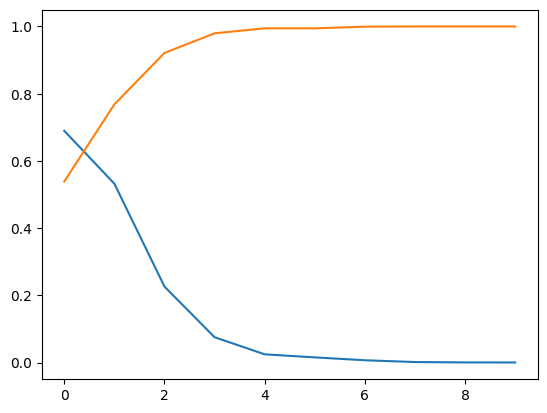

In [48]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])

In [49]:
print(model(padded_sequences).numpy().argmax(axis = 1))

[0 0 0 ... 0 0 0]


Model 1 Testing

In [50]:
loss, accuracy = model.evaluate(X_test, y_test)

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

18/18 [==============================] - 1s 52ms/step - loss: 2.2228 - accuracy: 0.5915
Test Loss: 2.2228
Test Accuracy: 59.15%


In [51]:
#Prection and Confusion Matrix
y_pred = model.predict(X_test)
bin_y_pred = (y_pred > 0.5).astype(int)

18/18 [==============================] - 1s 52ms/step


In [52]:
bin_y_pred = np.squeeze(bin_y_pred)

In [53]:
bin_y_pred

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,

In [54]:
from sklearn.metrics import confusion_matrix

In [55]:
y_true = y_test
y_pred = bin_y_pred

cm = confusion_matrix(y_true, y_pred)

TN, FP, FN, TP = cm.ravel()

print(f"{'':<20}{'Predicted No':<20}{'Predicted Yes':<20}")
print(f"{'Actual No':<20}{TN:<20}{FP:<20}")
print(f"{'Actual Yes':<20}{FN:<20}{TP:<20}")

                    Predicted No        Predicted Yes       
Actual No           180                 102                 
Actual Yes          130                 156                 


### MODEL 2

In [56]:
# We are going to build our model with the Sequential API
model2 = Sequential()

model2.add(Embedding(total_words,      # number of words to process as input
                    50,    # output representation
                    input_length=len(padded_sequences[0])))    # total length of each observation

model2.add(LSTM(50, return_sequences=False))

model2.add(Dropout(0.2))

model2.add(Dense(1, activation='sigmoid')) 

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 404, 50)           1046800   
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1067051 (4.07 MB)
Trainable params: 1067051 (4.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
model2.fit(X_train, y_train, epochs=5, validation_data = (X_val, y_val), callbacks=[early_stopping])

Epoch 1/5
57/57 [==============================] - 8s 115ms/step - loss: 0.6890 - accuracy: 0.5344 - val_loss: 0.6323 - val_accuracy: 0.6901
Epoch 2/5
57/57 [==============================] - 6s 107ms/step - loss: 0.5443 - accuracy: 0.7408 - val_loss: 0.6053 - val_accuracy: 0.6857
Epoch 3/5
57/57 [==============================] - 6s 106ms/step - loss: 0.2975 - accuracy: 0.8899 - val_loss: 0.8225 - val_accuracy: 0.6374
Epoch 4/5
57/57 [==============================] - 6s 106ms/step - loss: 0.1087 - accuracy: 0.9708 - val_loss: 0.9366 - val_accuracy: 0.6088
Epoch 5/5
57/57 [==============================] - 6s 107ms/step - loss: 0.0617 - accuracy: 0.9857 - val_loss: 1.1715 - val_accuracy: 0.6352


In [60]:
loss, accuracy = model2.evaluate(X_test, y_test)

18/18 [==============================] - 1s 37ms/step - loss: 0.6087 - accuracy: 0.6778


### MODEL 3

In [61]:
model3 = Sequential()

model3.add(Embedding(total_words,      # number of words to process as input
                    100,    # output representation
                    input_length=len(padded_sequences[0])))    # total length of each observation

model3.add(LSTM(100, return_sequences=False))

model3.add(Dense(1, activation='sigmoid')) 

model3.compile(optimizer='adam', loss='hinge', metrics=['accuracy'])

In [62]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 404, 100)          2093600   
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2174101 (8.29 MB)
Trainable params: 2174101 (8.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
his = model3.fit(X_train, y_train, epochs=5, validation_data = (X_val, y_val))

Epoch 1/5
57/57 [==============================] - 25s 418ms/step - loss: 0.9819 - accuracy: 0.5289 - val_loss: 0.9290 - val_accuracy: 0.6330
Epoch 2/5
57/57 [==============================] - 22s 381ms/step - loss: 0.9622 - accuracy: 0.5399 - val_loss: 1.0461 - val_accuracy: 0.4769
Epoch 3/5
57/57 [==============================] - 21s 373ms/step - loss: 0.9906 - accuracy: 0.5047 - val_loss: 1.0461 - val_accuracy: 0.4769
Epoch 4/5
57/57 [==============================] - 22s 389ms/step - loss: 0.9906 - accuracy: 0.5047 - val_loss: 1.0461 - val_accuracy: 0.4769
Epoch 5/5
57/57 [==============================] - 22s 379ms/step - loss: 0.9906 - accuracy: 0.5047 - val_loss: 1.0461 - val_accuracy: 0.4769


In [64]:
his.history

{'loss': [0.981853723526001,
  0.9622330665588379,
  0.9906451106071472,
  0.9906448721885681,
  0.9906448125839233],
 'accuracy': [0.528893768787384,
  0.5399009585380554,
  0.5046780109405518,
  0.5046780109405518,
  0.5046780109405518],
 'val_loss': [0.9290072321891785,
  1.0461472272872925,
  1.0461472272872925,
  1.046147346496582,
  1.0461472272872925],
 'val_accuracy': [0.6329670548439026,
  0.4769230782985687,
  0.4769230782985687,
  0.4769230782985687,
  0.4769230782985687]}

In [65]:
import matplotlib.pyplot as plt


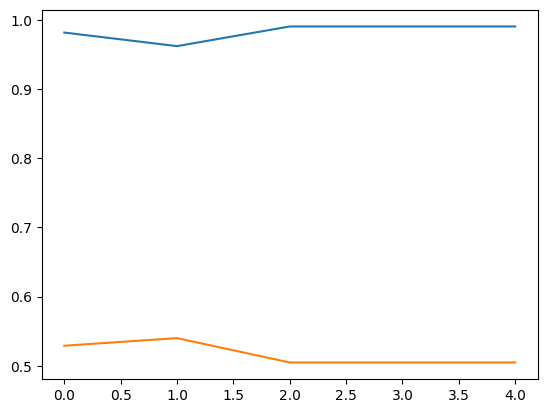

In [66]:
plt.plot(his.history['loss'])
plt.plot(his.history['accuracy'])

### MODEL 4

In [67]:
model4 = Sequential()

model4.add(Embedding(total_words,      # number of words to process as input
                    100,    # output representation
                    input_length=len(padded_sequences[0])))    # total length of each observation

model4.add(LSTM(100, return_sequences=False))

model4.add(Dense(1, activation='sigmoid')) 

model4.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [68]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 404, 100)          2093600   
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2174101 (8.29 MB)
Trainable params: 2174101 (8.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
his2 = model4.fit(X_train, y_train, epochs=5, validation_data = (X_val, y_val))

Epoch 1/5
57/57 [==============================] - 23s 396ms/step - loss: 0.6932 - accuracy: 0.4843 - val_loss: 0.6933 - val_accuracy: 0.5143
Epoch 2/5
57/57 [==============================] - 23s 407ms/step - loss: 0.6931 - accuracy: 0.5113 - val_loss: 0.6933 - val_accuracy: 0.5121
Epoch 3/5
57/57 [==============================] - 22s 383ms/step - loss: 0.6932 - accuracy: 0.4920 - val_loss: 0.6934 - val_accuracy: 0.4923
Epoch 4/5
57/57 [==============================] - 23s 408ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6935 - val_accuracy: 0.4769
Epoch 5/5
57/57 [==============================] - 23s 398ms/step - loss: 0.6931 - accuracy: 0.5091 - val_loss: 0.6935 - val_accuracy: 0.4725


### MODEL 5 (On Steriods)

In [161]:
adamax_opt = Adamax(learning_rate = 0.001)

In [162]:
model5 = Sequential()

model5.add(Embedding(total_words,      # number of words to process as input
                    100,    # output representation
                    mask_zero = True,
                    input_length=len(padded_sequences[0])))    # total length of each observation

model5.add(Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True)))

model5.add(Dropout(0.2)) 

model5.add(Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False)))
#model5.add(LSTM(100, return_sequences=False))

model5.add(Dropout(0.2)) 

model5.add(Dense(1, activation='sigmoid')) 

model5.compile(optimizer=adamax_opt, loss='binary_crossentropy', metrics=['accuracy'])

In [163]:
model5.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 404, 100)          2093600   
                                                                 
 bidirectional_38 (Bidirect  (None, 404, 200)          160800    
 ional)                                                          
                                                                 
 dropout_43 (Dropout)        (None, 404, 200)          0         
                                                                 
 bidirectional_39 (Bidirect  (None, 200)               240800    
 ional)                                                          
                                                                 
 dropout_44 (Dropout)        (None, 200)               0         
                                                                 
 dense_24 (Dense)            (None, 1)               

In [164]:
hist5 = model5.fit(X_train, y_train, epochs=10, validation_data = (X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
57/57 [==============================] - 111s 2s/step - loss: 0.6776 - accuracy: 0.5581 - val_loss: 0.5973 - val_accuracy: 0.6835
Epoch 2/10
57/57 [==============================] - 93s 2s/step - loss: 0.5393 - accuracy: 0.7364 - val_loss: 0.5814 - val_accuracy: 0.6835
Epoch 3/10
57/57 [==============================] - 93s 2s/step - loss: 0.4106 - accuracy: 0.8250 - val_loss: 0.6415 - val_accuracy: 0.6835
Epoch 4/10
57/57 [==============================] - 97s 2s/step - loss: 0.2657 - accuracy: 0.9026 - val_loss: 0.8069 - val_accuracy: 0.6549
Epoch 5/10
57/57 [==============================] - 95s 2s/step - loss: 0.1392 - accuracy: 0.9527 - val_loss: 0.9283 - val_accuracy: 0.6352


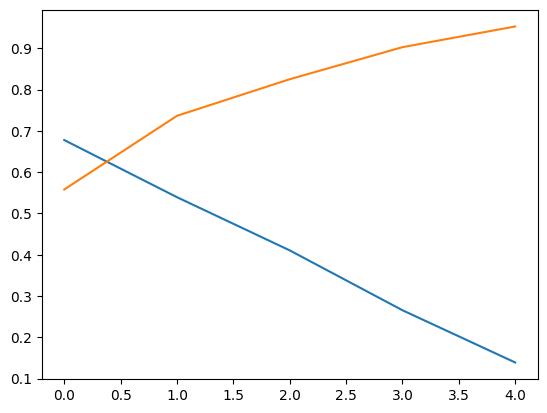

In [165]:
plt.plot(hist5.history['loss'])
plt.plot(hist5.history['accuracy'])

In [166]:
loss, accuracy = model5.evaluate(X_test, y_test)

18/18 [==============================] - 7s 384ms/step - loss: 0.5739 - accuracy: 0.7077


### MODEL 7

In [63]:
from tensorflow.keras.optimizers import Adamax

In [64]:
adamax_opt = Adamax(learning_rate = 0.001)

In [65]:
# We are going to build our model with the Sequential API
model7 = Sequential()

model7.add(Embedding(total_words,      # number of words to process as input
                    100,    # output representation
                    input_length=len(padded_sequences[0])))    # total length of each observation

model7.add(LSTM(100, return_sequences=False))
#model7.add(Bidirectional(LSTM(100, return_sequences=False)))

model7.add(Dropout(0.2))

model7.add(Dense(1, activation='sigmoid')) 

model7.compile(optimizer= adamax_opt, loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
hist7 = model7.fit(X_train, y_train, epochs=50, validation_data = (X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
57/57 [==============================] - 10s 146ms/step - loss: 0.6921 - accuracy: 0.5107 - val_loss: 0.6891 - val_accuracy: 0.5736
Epoch 2/50
57/57 [==============================] - 8s 139ms/step - loss: 0.6408 - accuracy: 0.6951 - val_loss: 0.6213 - val_accuracy: 0.6791
Epoch 3/50
57/57 [==============================] - 8s 141ms/step - loss: 0.5628 - accuracy: 0.7331 - val_loss: 0.5984 - val_accuracy: 0.6857
Epoch 4/50
57/57 [==============================] - 8s 141ms/step - loss: 0.5044 - accuracy: 0.7760 - val_loss: 0.5976 - val_accuracy: 0.6879
Epoch 5/50
57/57 [==============================] - 8s 141ms/step - loss: 0.4384 - accuracy: 0.8217 - val_loss: 0.6485 - val_accuracy: 0.6352
Epoch 6/50
57/57 [==============================] - 8s 142ms/step - loss: 0.3728 - accuracy: 0.8624 - val_loss: 0.6763 - val_accuracy: 0.7055
Epoch 7/50
57/57 [==============================] - 8s 142ms/step - loss: 0.2906 - accuracy: 0.9075 - val_loss: 0.6899 - val_accuracy: 0.6989


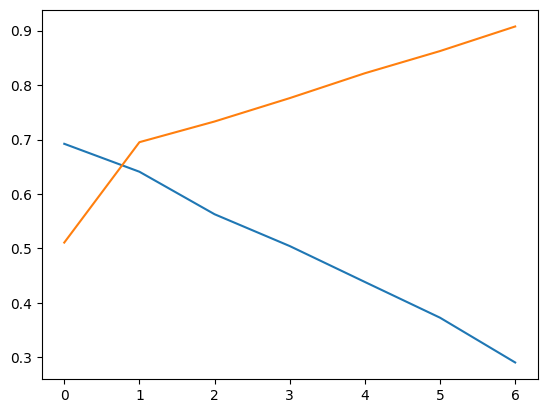

In [67]:
plt.plot(hist7.history['loss'])
plt.plot(hist7.history['accuracy'])

In [68]:
loss, accuracy = model7.evaluate(X_test, y_test)

18/18 [==============================] - 1s 52ms/step - loss: 0.5975 - accuracy: 0.6778


### MODEL 9

In [172]:
adamax_opt = Adamax(learning_rate = 0.001)

In [173]:
# We are going to build our model with the Sequential API
model9 = Sequential()

model9.add(Embedding(total_words,      # number of words to process as input
                    100,    # output representation
                    input_length=len(padded_sequences[0])))    # total length of each observation

#model9.add(LSTM(100, return_sequences=False))
model9.add(Bidirectional(LSTM(100, return_sequences=False)))

model9.add(Dropout(0.2))

model9.add(Dense(1, activation='sigmoid')) 

model9.compile(optimizer= adamax_opt, loss='binary_crossentropy', metrics=['accuracy'])

In [174]:
hist9 = model9.fit(X_train, y_train, epochs=50, validation_data = (X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
57/57 [==============================] - 66s 1s/step - loss: 0.6940 - accuracy: 0.4992 - val_loss: 0.6917 - val_accuracy: 0.5912
Epoch 2/50
57/57 [==============================] - 61s 1s/step - loss: 0.6570 - accuracy: 0.6637 - val_loss: 0.6145 - val_accuracy: 0.7011
Epoch 3/50
57/57 [==============================] - 59s 1s/step - loss: 0.5479 - accuracy: 0.7342 - val_loss: 0.6265 - val_accuracy: 0.7033
Epoch 4/50
57/57 [==============================] - 58s 1s/step - loss: 0.4575 - accuracy: 0.8019 - val_loss: 0.6566 - val_accuracy: 0.6901
Epoch 5/50
57/57 [==============================] - 61s 1s/step - loss: 0.3627 - accuracy: 0.8619 - val_loss: 0.7681 - val_accuracy: 0.6813


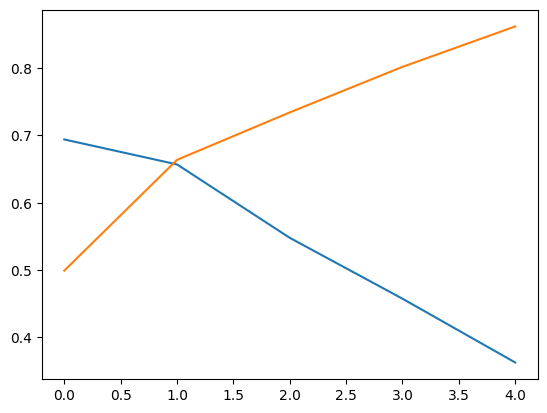

In [175]:
plt.plot(hist9.history['loss'])
plt.plot(hist9.history['accuracy'])

In [176]:
loss, accuracy = model9.evaluate(X_test, y_test)

18/18 [==============================] - 3s 186ms/step - loss: 0.6025 - accuracy: 0.6919
